# Optimizing Online Sports Retail Revenue Project #

 In this notebook, we play the role of a product analyst for an online sports clothing company. The company is specifically interested in how it can improve revenue. We will dive into product data such as pricing, reviews, descriptions, and ratings, as well as revenue and website traffic, to produce recommendations for its marketing and sales teams.

#### The database consists of 5 tables: ####
    1. info
    2. finance
    3. reviews
    4. traffic
    5. brands
#### All tables have a "product_id" column as __PRIMARY KEY__ ####
- - - -

## 1. Setting the required libraries and establishing the connection ###

In [1]:
# to deal with the database
import mysql.connector as connector

# to deal with dataframes and matrices
import pandas as pd
import numpy as np

# for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# for variables environment
import os
from dotenv import load_dotenv

# to hide warning messages in plots
import warnings
warnings.filterwarnings('ignore')

In [2]:
# just to center the plots
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [3]:
# set font style
font = {'fontname':'monospace'}

In [4]:
load_dotenv()
ENV_MYSQL_USER = os.getenv('MYSQL_USER')
ENV_MYSQL_PASSWORD = os.getenv('MYSQL_PASSWORD')
ENV_MYSQL_HOST = os.getenv('MYSQL_HOST')

connection = connector.connect(
    username=ENV_MYSQL_USER,
    password=ENV_MYSQL_PASSWORD,
    host=ENV_MYSQL_HOST,
    port=3306,
    database="sports_store"
)

In [5]:
cursor = connection.cursor()

- - - -

## 2. Creating some functions that will help through the project ##

In [6]:
def create_dataframe(columns, results):
    '''
    This function converts the results into pandas dataframe just to simplify its reading
    :param columns -> the headers of the results
    :param results -> the results themselves
    '''
    df = pd.DataFrame(results, columns=columns)
    df = df.style.set_table_styles([{"selector": "td, th", "props": [("border", "1px solid grey !important")]},
                                    {"selector": "th", "props": [('text-align', 'center')]}])
    df = df.set_properties(**{'text-align': 'center'}).hide_index()
    return df

In [7]:
def show_columns(table):
    '''
    This function simply shows the columns of the table specified
    :param table -> the name of the table that you want to show its columns
    '''
    cursor.execute("""SHOW COLUMNS FROM {};""".format(table))
    columns = cursor.fetchall()
    print("Columns of {} table are:".format(table))
    for number, column in enumerate(columns):
        print(str(number+1) + ") " + column[0], end="\n")

In [8]:
def show_first_ten_results(table):
    '''
    This function shows the first 10 products of the table specified
    :param table -> the name of the table that you want to show its first 10 results
    '''
    cursor.execute("""SELECT * FROM {} ORDER BY product_id LIMIT 10;""".format(table))
    columns = cursor.column_names
    results = cursor.fetchall()
    df = create_dataframe(columns, results) # To return resutls in the form of a dataframe
    return df

In [9]:
def make_autopct(values):
    '''
    This function sets the autopct for pie charts as I want to appear
    :param values -> the data which is shown in the pie
    '''
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

- - - -

## 3. Explore the data stored in the database ##

### 3.1. Show the columns of the tables in the database ###

In [10]:
show_columns("info")

Columns of info table are:
1) product_name
2) product_id
3) description


In [11]:
show_columns("finance")

Columns of finance table are:
1) product_id
2) listing_price
3) sale_price
4) discount
5) revenue


In [12]:
show_columns("reviews")

Columns of reviews table are:
1) product_id
2) rating
3) reviews


In [13]:
show_columns("traffic")

Columns of traffic table are:
1) product_id
2) last_visited


In [14]:
show_columns("brands")

Columns of brands table are:
1) product_id
2) brand


### 3.2. Show top 10 records in each table as dataframe ###

In [15]:
display(show_first_ten_results("info"))

product_name,product_id,description
Air Jordan 12 Retro,130690-017,"An all-time favourite among players and sneakerheads, the Air Jordan 12 Retro features full-length Zoom Air cushioning and full-grain leather styled with distinct radial stitch lines."
Air Jordan OG,133000-106,"First released in '98, the Air Jordan OG was designed for the women's basketball community who wanted an AJ all of their own. The original Air Jordan for women has dimpled leather and midsole sculpting inspired by the AJ13."
Men's Originals Summer Adilette Slippers,280648,"From 72' until now, these adidas Originals Sandals have been a favorite pick amongst the crowd. Quick drying functionality makes it a perfect outdoor as well as an indoor footwear. Distinct designing offers both style and comfort."
Men's Originals Summer Adilette Slides,288022,The adidas Originals Adilette slip ons for men. The Rubber sole keeps your feet in supreme comfort and it comes with 3-Stripes on the upper Synthetic bandage.
Air Jordan 10 Retro,310805-137,"Featuring soft, lightweight cushioning, the Air Jordan 10 Retro offers performance-inspired comfort with iconic Air Jordan detailing."
Air Jordan 7 Retro,313358-006,"The Air Jordan 7 Retro celebrates MJ's championship legacy with a reissue of his 7th game shoe, the one he famously wore to gold-medal glory."
Nike Air Force 1 '07,315115-112,"The radiance lives on in the Nike Air Force 1 '07, the b-ball OG that puts a fresh spin on what you know best: crisp leather in an all-white colourway for a statement look on and off the court."
Nike Air Force 1 '07,315122-001,"Hoops in the park, Sunday BBQs and sunshine. The radiance lives on in the Nike Air Force 1 '07, the b-ball OG that puts a fresh spin on what you know best: crisp leather in an all-black colourway for a statement look on and off the court."
Nike Air Force 1 Mid '07,315123-111,"The legend lives on in the Nike Air Force 1 Mid '07 Men's Shoe, a modern take on the icon that blends classic style and fresh, crisp details."
Nike Air Max 90,325213-139,The Nike Air Max 90 Women's Shoe honours its roots with a supportive upper and the excellent cushioning that made the original a favourite.


In [16]:
display(show_first_ten_results("reviews"))

product_id,rating,reviews
130690-017,4.5,24
133000-106,0.0,0
280648,4.2,54
288022,3.3,95
310805-137,4.7,223
313358-006,4.8,4
315115-112,4.5,67
315122-001,4.5,78
315123-111,4.5,13
325213-139,3.6,5


In [17]:
display(show_first_ten_results("finance"))

product_id,listing_price,sale_price,discount,revenue
130690-017,0.00,159.95,0.00,6909.84
133000-106,0.00,119.95,0.00,0.00
280648,29.99,29.99,0.00,2915.03
288022,29.99,29.99,0.00,5128.29
310805-137,0.00,159.95,0.00,64203.93
313358-006,159.95,111.97,0.00,806.18
315115-112,0.00,74.95,0.00,9038.97
315122-001,0.00,72.95,0.00,10242.18
315123-111,0.00,75.95,0.00,1777.23
325213-139,94.95,75.97,0.00,683.73


In [18]:
display(show_first_ten_results("traffic"))

product_id,last_visited
130690-017,2019-07-29 21:21:00
133000-106,2018-08-21 01:30:00
280648,2019-05-01 00:39:00
288022,2019-10-02 11:04:00
310805-137,2019-07-25 17:17:00
313358-006,2018-10-06 14:02:00
315115-112,2020-02-01 00:48:00
315122-001,2020-03-06 01:08:00
315123-111,2018-10-11 16:29:00
325213-139,2018-07-28 15:17:00


In [19]:
display(show_first_ten_results("brands"))

product_id,brand
130690-017,Nike
133000-106,Nike
280648,Adidas
288022,Adidas
310805-137,Nike
313358-006,Nike
315115-112,Nike
315122-001,Nike
315123-111,Nike
325213-139,Nike


- - - -

## 4. Project Tasks ##

### Task 1: Counting missing values ###

In [20]:
non_missing_records = """
    SELECT COUNT(*) AS total_rows,
        COUNT(I.description) AS count_description,
        COUNT(F.listing_price) AS count_listing_price,
        COUNT(T.last_visited) AS count_last_visited
    FROM info AS I
    INNER JOIN finance AS F
        ON F.product_id = I.product_id
    INNER JOIN traffic AS T
        ON T.product_id = I.product_id;
"""

cursor.execute(non_missing_records)
columns = cursor.column_names
results = cursor.fetchall()
create_dataframe(columns, results)

total_rows,count_description,count_listing_price,count_last_visited
3179,3179,3179,3179


- - - -

### Task 2: Nike VS. Adidas pricing ###

In [21]:
prices_in_adidas_vs_nike = """
    SELECT B.brand, FORMAT(F.listing_price, 0) AS listing_price, COUNT(*) AS number_of_products
    FROM brands AS B
    INNER JOIN finance AS F
        ON F.product_id = B.product_id
    WHERE F.listing_price > 0
    GROUP BY B.brand, F.listing_price
    ORDER BY F.listing_price DESC;
"""

cursor.execute(prices_in_adidas_vs_nike)
columns = cursor.column_names
results = cursor.fetchall()
create_dataframe(columns, results)

brand,listing_price,number_of_products
Adidas,300,2
Adidas,280,4
Adidas,240,5
Adidas,230,8
Adidas,220,11
Adidas,200,8
Nike,200,1
Adidas,190,7
Nike,190,2
Adidas,180,34


- - - -

### Task 3: Labeling price ranges ###

#### 3.1. Retrieving data from the database ####

In [22]:
pricing_labels = """
    SELECT B.brand, SUM(F.revenue) AS total_revenue,
        CASE
            WHEN F.listing_price < 42 THEN "Budget"
            WHEN F.listing_price >= 42 AND F.listing_price < 74 THEN "Average"
            WHEN F.listing_price >= 74 AND F.listing_price < 129 THEN "Expensive"
            ELSE "Elite"
        END AS price_category
    FROM brands AS B
    INNER JOIN finance AS F
        ON F.product_id = B.product_id
    WHERE B.brand != ""
    GROUP BY B.brand, price_category
    ORDER BY total_revenue DESC;
"""

cursor.execute(pricing_labels)
columns = cursor.column_names
results = cursor.fetchall()
labels = create_dataframe(columns, results)
display(labels)

brand,total_revenue,price_category
Adidas,4626980.07,Expensive
Adidas,3233661.06,Average
Adidas,3014316.83,Elite
Adidas,651661.12,Budget
Nike,595341.02,Budget
Nike,128475.59,Elite
Nike,71843.15,Expensive
Nike,6623.50,Average


#### 3.2. Data cleaning ####

In [23]:
labels = labels.data
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand           8 non-null      object
 1   total_revenue   8 non-null      object
 2   price_category  8 non-null      object
dtypes: object(3)
memory usage: 320.0+ bytes


In [24]:
labels['total_revenue'] = labels['total_revenue'].astype('float')
labels['total_revenue'] = pd.to_numeric(labels['total_revenue'])

In [25]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           8 non-null      object 
 1   total_revenue   8 non-null      float64
 2   price_category  8 non-null      object 
dtypes: float64(1), object(2)
memory usage: 320.0+ bytes


#### 3.3. Visualization ####

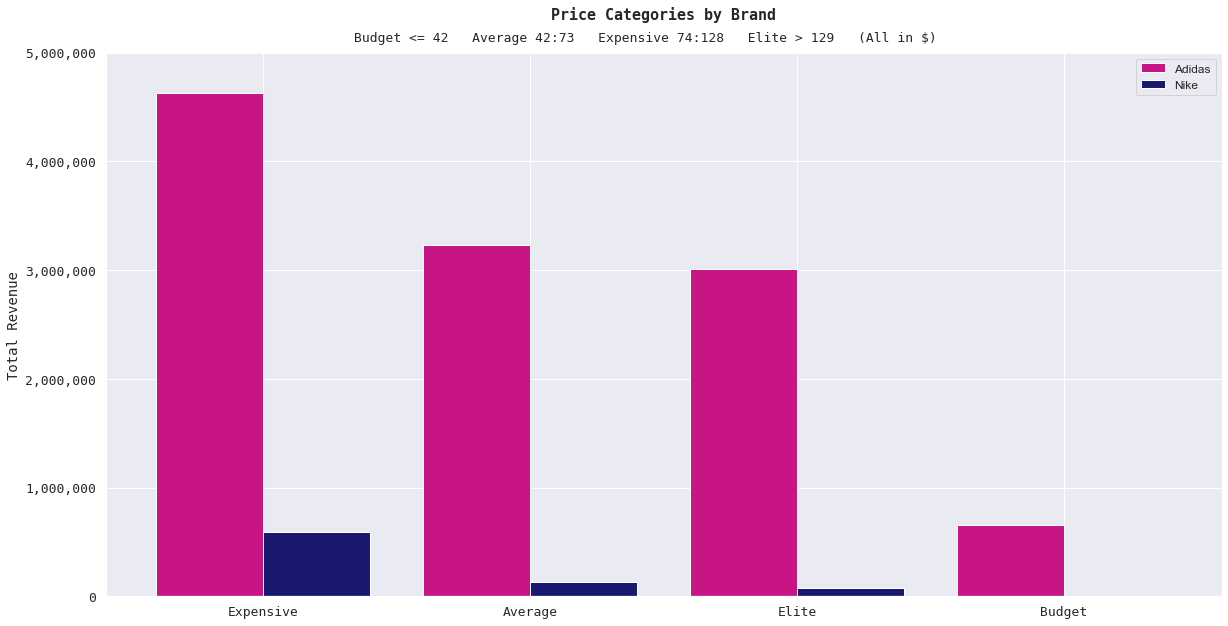

In [26]:
adidas = labels[labels['brand']=="Adidas"]
nike = labels[labels['brand']=="Nike"]

x_pos = np.arange(len(adidas))
tick_labels = labels['price_category'].unique()

plt.figure(figsize=(20, 10))
plt.bar(x_pos - 0.2, adidas['total_revenue'], width=0.4, label='Adidas', color="mediumvioletred")
plt.bar(x_pos + 0.2, nike['total_revenue'], width=0.4, label='Nike', color="midnightblue")
plt.title("Price Categories by Brand", fontsize=15, fontweight="bold", fontname="monospace", y=1.05)
plt.suptitle("Budget <= 42   Average 42:73   Expensive 74:128   Elite > 129   (All in $)", fontsize=13, fontname="monospace", y=0.91)
plt.ylabel("Total Revenue", fontsize=14, fontname="monospace")
plt.ylim([0, 5000000])
plt.xticks(x_pos, tick_labels, fontsize=13, fontname="monospace")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.yticks(fontsize=13, fontname="monospace")
plt.legend(fontsize='medium')
plt.show()

- - - -

### Task 4: Average discount by brand ###

In [27]:
discount = """
    SELECT B.brand, CONCAT(ROUND(AVG(F.discount)*100, 2), "%") AS average_discount
    FROM brands AS B
    INNER JOIN finance AS F
        ON F.product_id = B.product_id
    GROUP BY B.brand
    HAVING B.brand != "";
"""

cursor.execute(discount)
columns = cursor.column_names
results = cursor.fetchall()
create_dataframe(columns, results)

brand,average_discount
Adidas,33.45%
Nike,0.00%


- - - -

### Task 5: Correlation between *revenue* and *reviews* ###

#### 5.1. Retrieving data from the database ####

In [28]:
correlation = """
    SELECT R.reviews AS number_of_reviews, ROUND(AVG(F.revenue), 2) AS average_revenue
    FROM reviews AS R
    INNER JOIN finance AS F
        ON F.product_id = R.product_id
    GROUP BY number_of_reviews
    ORDER BY number_of_reviews DESC;
"""

cursor.execute(correlation)
columns = cursor.column_names
results = cursor.fetchall()
revenue_reviews = create_dataframe(columns, results)
display(revenue_reviews)

number_of_reviews,average_revenue
223,64203.93
105,27395.55
99,7391.74
98,8360.92
97,8432.30
96,8717.54
95,7228.17
94,11153.95
93,10339.85
92,7084.17


In [29]:
# 1. Turn df from styler type to dataframe type as it need to be
revenue_reviews = revenue_reviews.data
# 2. turn the *revenue*  column into float instead of object(string)
revenue_reviews['average_revenue'] = revenue_reviews['average_revenue'].astype('float')

# 3. Get the correlation coefficient
corr_coeff = revenue_reviews['average_revenue'].corr(revenue_reviews['number_of_reviews'])
print("Correlation coefficient between number of reviews and average revenue for the products which have the same number of reviews: {}"
      .format(round(corr_coeff, 4)))

Correlation coefficient between number of reviews and average revenue for the products which have the same number of reviews: 0.8033


#### 5.2. Visualization ####

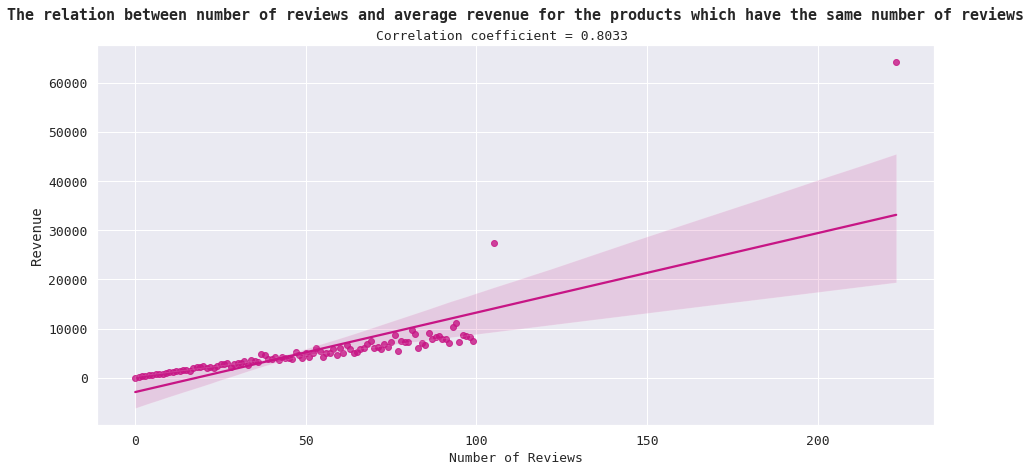

In [30]:
figure = plt.figure(figsize=(15, 7))
sns.regplot(revenue_reviews['number_of_reviews'], revenue_reviews['average_revenue'], revenue_reviews, color="mediumvioletred")
plt.xlabel("Number of Reviews", fontsize=13, fontname="monospace")
plt.ylabel("Revenue", fontsize=14, fontname="monospace")
plt.title("The relation between number of reviews and average revenue for the products which have the same number of reviews",
          y=1.05, fontsize=15, fontweight="bold", fontname="monospace")
plt.suptitle("Correlation coefficient = {}".format(round(corr_coeff, 4)), y=0.91, fontsize=13, fontname="monospace")
plt.xticks(fontsize=13, fontname="monospace")
plt.yticks(fontsize=13, fontname="monospace")
plt.show()

<div align="center">
    It's obvious now that the more the number of reviews, the more the company gains revenue. Maybe this happens because people trust the products with more reviews than the others.
</div>

#### 5.3. Let's investigate the first outlier! #####

<div align="center">
    As shown above, there's an outlier in the plot which has the biggest number of reviews and relatively the highest revenue.
    <br>
    Let's investigate !
</div>

In [31]:
# the top 5 products according to number of reviews
create_dataframe(columns, revenue_reviews.head().sort_values(['number_of_reviews'], ascending=False))

number_of_reviews,average_revenue
223,64203.930000
105,27395.550000
99,7391.740000
98,8360.920000
97,8432.300000


In [32]:
# find the index of the first outlier
max_number_of_reviews = revenue_reviews['number_of_reviews'].max() # 223 from the previous table
index_of_max = revenue_reviews['number_of_reviews'].idxmax()

print("The product which has the maximum number of reviews ({}) is at ({}) index in the dataframe"
      .format(max_number_of_reviews, index_of_max))

The product which has the maximum number of reviews (223) is at (0) index in the dataframe


In [33]:
# show the record
revenue_reviews.loc[0]

number_of_reviews      223.00
average_revenue      64203.93
Name: 0, dtype: float64

In [34]:
# get the product id of this product
product_id = """
    SELECT R.product_id, R.reviews, F.revenue
    FROM reviews AS R
    INNER JOIN finance AS F
        ON F.product_id = R.product_id
    WHERE R.reviews = 223;
"""

cursor.execute(product_id)
columns = cursor.column_names
results = cursor.fetchall()
create_dataframe(columns, results)

product_id,reviews,revenue
310805-137,223,64203.93


<div align="center">
    So, there's only one product which has this number of reviews, and this amount of revenue has been achieved from this product only!
    <br>
    This product's id is (310805-137) 
</div>

In [35]:
# get the name of product
product_name = """
    SELECT I.product_id, I.product_name, B.brand, T.last_visited, I.description
    FROM info AS I
    INNER JOIN brands AS B
        ON B.product_id = I.product_id
    INNER JOIN traffic AS T
        ON T.product_id = I.product_id
    WHERE I.product_id = "310805-137";
"""

cursor.execute(product_name)
columns = cursor.column_names
results = cursor.fetchall()
create_dataframe(columns, results)

product_id,product_name,brand,last_visited,description
310805-137,Air Jordan 10 Retro,Nike,2019-07-25 17:17:00,"Featuring soft, lightweight cushioning, the Air Jordan 10 Retro offers performance-inspired comfort with iconic Air Jordan detailing."


<div align="center">    
    Now we've reached the best selling product in the store. It is the "Air Jordan 10 Retro" and figured out that it's from Nike!!
</div>

#### 5.4. What about the second outlier ? ####

In [36]:
# the second outlier has number of reviews = 105
second_outlier = revenue_reviews[revenue_reviews['number_of_reviews']==105]
display(second_outlier)

,number_of_reviews,average_revenue
1,105,27395.55


In [37]:
# let's see its id
product_id = """
    SELECT R.product_id, R.reviews, F.revenue
    FROM reviews AS R
    INNER JOIN finance AS F
        ON F.product_id = R.product_id
    WHERE R.reviews = 105;
"""

cursor.execute(product_id)
columns = cursor.column_names
results = cursor.fetchall()
create_dataframe(columns, results)

product_id,reviews,revenue
880848-005,105,27395.55


In [38]:
# get more information about it
product_name = """
    SELECT I.product_id, I.product_name, B.brand, T.last_visited, I.description
    FROM info AS I
    INNER JOIN brands AS B
        ON B.product_id = I.product_id
    INNER JOIN traffic AS T
        ON T.product_id = I.product_id
    WHERE I.product_id = "880848-005";
"""

cursor.execute(product_name)
columns = cursor.column_names
results = cursor.fetchall()
create_dataframe(columns, results)

product_id,product_name,brand,last_visited,description
880848-005,Nike Zoom Fly,Nike,2018-05-03 18:42:00,"Built with a carbon-infused nylon plate inspired by the VaporFly 4%—our most efficient marathon shoe ever—the Nike Zoom Fly Men's Running Shoe is the perfect response to the demands of your toughest tempo runs, long runs and race days."


<div align="center">
    It's from Nike too !!!
</div>

In [39]:
# let's zoom in the last_visited column and show when the top 2 products last visited in the whole website!
traffic_product = """
    SELECT T.product_id, T.last_visited, B.brand
    FROM traffic AS T
    INNER JOIN brands AS B
        ON B.product_id = T.product_id
    ORDER BY T.last_visited DESC
    LIMIT 20;
"""

cursor.execute(traffic_product)
columns = cursor.column_names
results = cursor.fetchall()
create_dataframe(columns, results)

product_id,last_visited,brand
CJ8116,2020-04-12 19:00:00,Adidas
CI3869-500,2020-04-12 19:00:00,Nike
CD0917-300,2020-04-12 13:44:00,Nike
F36236,2020-04-12 08:28:00,Adidas
CL4156,2020-04-12 07:09:00,Adidas
CK0986-002,2020-04-11 15:21:00,Nike
AJ7695-100,2020-04-11 15:21:00,Nike
EG7972,2020-04-11 11:24:00,Adidas
EE4919,2020-04-11 10:05:00,Adidas
EF4001,2020-04-11 10:05:00,Adidas


<div align="center">
    Despite these products' huge achieved revenue and number of reviews, they have been last visited in 2019 and 2018!! and this is not even from the first 20 records of the whole website's data!
    <br>
    Maybe this is because Nike decided to stop producing it, but they should think again about this decision!
</div>

- - - -

### Task 6: Ratings and reviews by product description length ###

In [40]:
description_length = """
    SELECT TRUNCATE(LENGTH(I.description), -2) AS description_length,
        ROUND(AVG(R.rating), 2) AS average_rating
    FROM info AS I
    INNER JOIN reviews AS R
        ON R.product_id = I.product_id
    WHERE description != ""
    GROUP BY description_length
    ORDER BY description_length DESC;
"""

cursor.execute(description_length)
columns = cursor.column_names
results = cursor.fetchall()

create_dataframe(columns, results)

description_length,average_rating
500,3.39
400,3.32
300,3.29
200,3.27
100,3.21
0,1.87


- - - -

### Task 7: Reviews by month and brand ###

#### 7.1. Retrieving data from the database ####

In [41]:
brands_reviews = """
    SELECT B.brand, MONTH(T.last_visited) AS month, COUNT(R.product_id) AS num_reviews
    FROM brands AS B
    INNER JOIN traffic AS T
        ON T.product_id = B.product_id
    INNER JOIN reviews AS R
        ON R.product_id = B.product_id
    GROUP BY B.brand, month
    HAVING B.brand != "" AND month != ""
    ORDER BY B.brand, month;
"""

cursor.execute(brands_reviews)
columns = cursor.column_names
results = cursor.fetchall()

monthly_reviews = create_dataframe(columns, results)
display(monthly_reviews)

brand,month,num_reviews
Adidas,1,253
Adidas,2,272
Adidas,3,269
Adidas,4,180
Adidas,5,172
Adidas,6,159
Adidas,7,170
Adidas,8,189
Adidas,9,181
Adidas,10,192


#### 7.2. Data transformation ####

In [42]:
monthly_reviews = monthly_reviews.data
monthly_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   brand        24 non-null     object
 1   month        24 non-null     int64 
 2   num_reviews  24 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 704.0+ bytes


In [43]:
monthly_reviews['month'] = pd.to_datetime(monthly_reviews['month'], format='%m').dt.month_name()
display(monthly_reviews)

,brand,month,num_reviews
0,Adidas,January,253
1,Adidas,February,272
2,Adidas,March,269
3,Adidas,April,180
4,Adidas,May,172
5,Adidas,June,159
6,Adidas,July,170
7,Adidas,August,189
8,Adidas,September,181
9,Adidas,October,192


In [44]:
monthly_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   brand        24 non-null     object
 1   month        24 non-null     object
 2   num_reviews  24 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 704.0+ bytes


#### 7.3. Visualization ####

In [45]:
# dataframe for adidas only, and extracting the maximum and minimum points
adidas = monthly_reviews[monthly_reviews['brand']=="Adidas"]
max_adidas_reviews = adidas['num_reviews'].max()
max_adidas_month = adidas.loc[adidas['num_reviews']==max_adidas_reviews].month
min_adidas_reviews = adidas['num_reviews'].min()
min_adidas_month = adidas.loc[adidas['num_reviews']==min_adidas_reviews].month

# dataframe for nike only, and extracting the maximum and minimum points
nike = monthly_reviews[monthly_reviews['brand']=="Nike"]
max_nike_reviews = nike['num_reviews'].max()
max_nike_month = nike.loc[nike['num_reviews']==max_nike_reviews].month
min_nike_reviews = nike['num_reviews'].min()
min_nike_month = nike.loc[nike['num_reviews']==min_nike_reviews].month

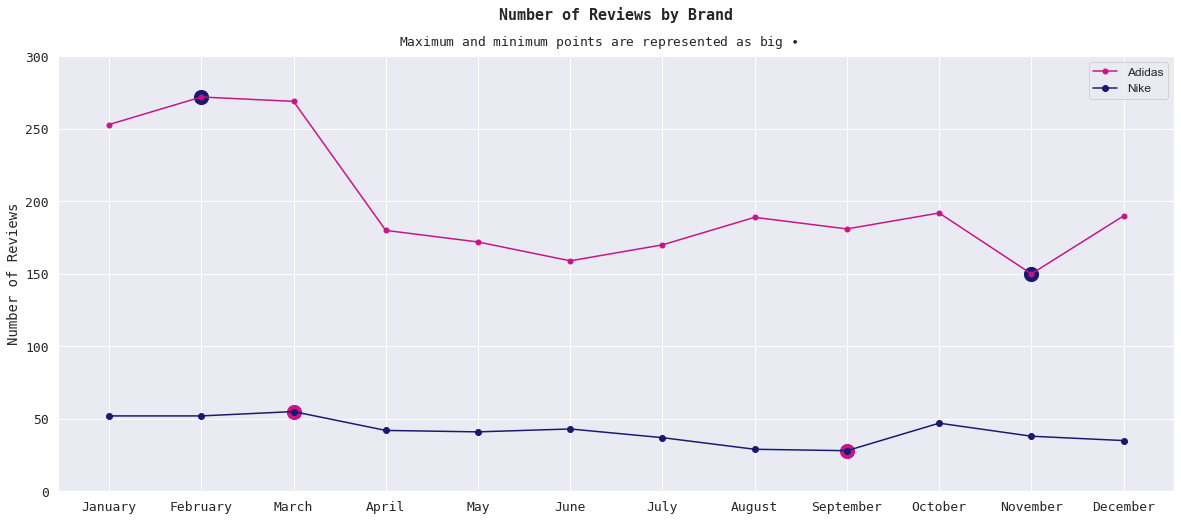

In [46]:
figure = plt.figure(figsize=(20, 8))
plt.plot(adidas['month'], adidas['num_reviews'], color="mediumvioletred", label="Adidas", marker='o', markersize=5)
plt.scatter(max_adidas_month, max_adidas_reviews, s=200, color='midnightblue')
plt.scatter(min_adidas_month, min_adidas_reviews, s=200, color='midnightblue')

plt.plot(nike['month'], nike['num_reviews'], color="midnightblue", label="Nike", marker='o')
plt.scatter(max_nike_month, max_nike_reviews, s=200, color='mediumvioletred')
plt.scatter(min_nike_month, min_nike_reviews, s=200, color='mediumvioletred')

plt.title("Number of Reviews by Brand", fontsize=15, fontweight="bold", fontname="monospace", y=1.07)
plt.suptitle("Maximum and minimum points are represented as big {}".format(r'$\bullet$'),
             fontsize=13,fontname="monospace", y=0.92)
plt.ylabel("Number of Reviews", fontsize=14, fontname="monospace")
plt.ylim([0, 300])
plt.xticks(fontsize=13, fontname="monospace")
plt.yticks(fontsize=13, fontname="monospace")
plt.legend(fontsize='medium')
plt.show()

- - - -

### Task 8: Footwear product performance ###

#### 8.1. Retrieving data from the database ####

In [47]:
footwear = """
    WITH footwear AS(
        SELECT LOWER(I.description) AS description, F.revenue
        FROM info AS I
        INNER JOIN finance AS F
            ON F.product_id = I.product_id
        WHERE description LIKE "%shoe%"
            OR description LIKE "%trainer%"
            OR description LIKE "%foot%"
            AND description != ""
    )

    SELECT COUNT(*) AS number_of_footwears FROM footwear;
"""

cursor.execute(footwear)
columns = cursor.column_names
results = cursor.fetchall()

footwear = create_dataframe(columns, results).data
display(footwear)

,number_of_footwears
0,2700


In [48]:
# To get the median of total revenue for foatwear

revenue = """
    WITH footwear AS(
        SELECT LOWER(I.description) AS description, F.revenue
        FROM info AS I
        INNER JOIN finance AS F
            ON F.product_id = I.product_id
        WHERE description LIKE "%shoe%"
            OR description LIKE "%trainer%"
            OR description LIKE "%foot%"
            AND description != ""
    )
    
    SELECT revenue FROM finance;
"""

cursor.execute(revenue)
results = cursor.fetchall()

footwear['median_footwear_revenue'] = np.median(results)

create_dataframe(footwear.columns, footwear)

number_of_footwears,median_footwear_revenue
2700,2653.94


- - - -

### Task 9: Clothing product performance ###

#### 9.1. Retrieving data from the database ####

In [49]:
not_footwear = """
    WITH footwear AS(
        SELECT LOWER(I.description) AS description, F.revenue
        FROM info AS I
        INNER JOIN finance AS F
            ON F.product_id = I.product_id
        WHERE description LIKE "%shoe%"
            OR description LIKE "%trainer%"
            OR description LIKE "%foot%"
            AND description != ""
    )

    SELECT COUNT(*) AS number_of_non_footwears FROM info
    WHERE description NOT IN (SELECT description FROM footwear);
"""

cursor.execute(not_footwear)
columns = cursor.column_names
results = cursor.fetchall()

not_footwear = create_dataframe(columns, results).data
display(not_footwear)

,number_of_non_footwears
0,479


In [50]:
revenue = """
    WITH footwear AS(
        SELECT LOWER(I.description) AS description, F.revenue
        FROM info AS I
        INNER JOIN finance AS F
            ON F.product_id = I.product_id
        WHERE description LIKE "%shoe%"
            OR description LIKE "%trainer%"
            OR description LIKE "%foot%"
            AND description != ""
    )
    
    SELECT F.revenue FROM finance AS F
    INNER JOIN info AS I
        ON I.product_id = F.product_id
    WHERE I.description NOT IN (SELECT description FROM footwear);
"""

cursor.execute(revenue)
results = cursor.fetchall()

not_footwear['median_footwear_revenue'] = np.median(results)

create_dataframe(not_footwear.columns, not_footwear)

number_of_non_footwears,median_footwear_revenue
479,388.37


- - - -

### Visualization (Task 8 & 9) ###

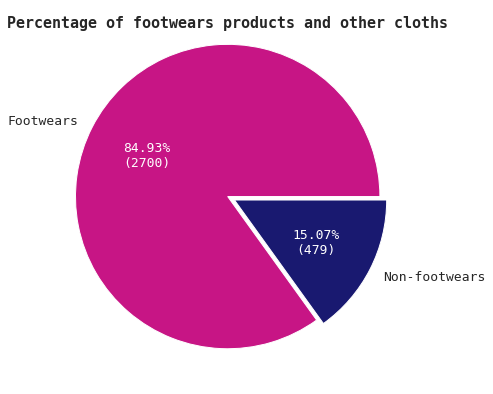

In [51]:
cloths = [footwear['number_of_footwears'][0], not_footwear['number_of_non_footwears'][0]]

figure = plt.figure(figsize=(7, 7))
_, _, autotexts = plt.pie(cloths, explode=[0, 0.05],
                          labels=['Footwears', 'Non-footwears'],
                          autopct=make_autopct(cloths), colors=["mediumvioletred", "midnightblue"],
                          textprops={"fontsize":13, "fontname": "monospace"})
for autotext in autotexts:
    autotext.set_color('white')
plt.title("Percentage of footwears products and other cloths", fontsize=15, fontweight="bold", fontname="monospace",  y=0.93)
plt.show()

- - - -

## 5. Some extra Information ##

### 5.1. Website's traffic along quarters by brand ###

#### 5.1.1. Retrieving data from the database ####

In [52]:
traffic_brand = """
    SELECT T.*, B.brand
    FROM traffic AS T
    INNER JOIN brands AS B
        ON B.product_id = T.product_id
    WHERE B.brand != "";
"""
cursor.execute(traffic_brand)
columns = cursor.column_names
results = cursor.fetchall()
traffic_brand = create_dataframe(columns, results).data
display(traffic_brand.head())

,product_id,last_visited,brand
0,G27341,2018-11-29 16:16:00,Adidas
1,CM0081,2018-02-01 10:27:00,Adidas
2,B44832,2018-09-07 20:06:00,Adidas
3,D98205,2019-07-18 15:26:00,Adidas
4,B75586,2019-01-30 12:09:00,Adidas


#### 5.1.2. Data cleaning and transformation ####

In [53]:
# drop empty dates
traffic_brand.dropna(inplace=True)

In [54]:
# extract years with quarters
traffic_brand['year/quarter'] = pd.to_datetime(traffic_brand['last_visited']).dt.to_period('Q')
traffic_brand.head()

,product_id,last_visited,brand,year/quarter
0,G27341,2018-11-29 16:16:00,Adidas,2018Q4
1,CM0081,2018-02-01 10:27:00,Adidas,2018Q1
2,B44832,2018-09-07 20:06:00,Adidas,2018Q3
3,D98205,2019-07-18 15:26:00,Adidas,2019Q3
4,B75586,2019-01-30 12:09:00,Adidas,2019Q1


In [55]:
traffic_brand['quarter'] = traffic_brand['year/quarter'].astype('str').str.slice(4, 6)
traffic_brand.head()

,product_id,last_visited,brand,year/quarter,quarter
0,G27341,2018-11-29 16:16:00,Adidas,2018Q4,Q4
1,CM0081,2018-02-01 10:27:00,Adidas,2018Q1,Q1
2,B44832,2018-09-07 20:06:00,Adidas,2018Q3,Q3
3,D98205,2019-07-18 15:26:00,Adidas,2019Q3,Q3
4,B75586,2019-01-30 12:09:00,Adidas,2019Q1,Q1


#### 5.1.3. Visualization ####

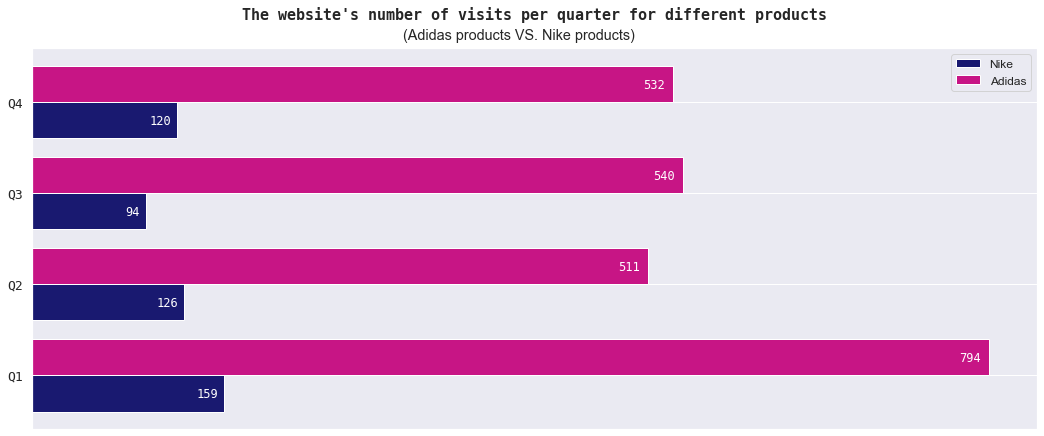

In [56]:
# draw number of products visited per quarter by brand

quarters = np.sort(traffic_brand['quarter'].unique())
number_of_visits_adidas = traffic_brand[traffic_brand['brand']=="Adidas"].groupby('quarter')['product_id'].count().to_list()
number_of_visits_nike = traffic_brand[traffic_brand['brand']=="Nike"].groupby('quarter')['product_id'].count().to_list()

ind = np.arange(len(quarters))
width = 0.4

figure = plt.figure(figsize=(18,7))
plt.barh(ind, number_of_visits_nike, width, color="midnightblue", label="Nike")
for i, v in enumerate(number_of_visits_nike):
    plt.text(v-5, i-0.04, str(v), color='white', fontname="monospace", fontsize=12, horizontalalignment="right")
plt.barh(ind + width, number_of_visits_adidas, width, color="mediumvioletred", label="Adidas")
for i, v in enumerate(number_of_visits_adidas):
    plt.text(v-25, i + .35, str(v), color='white', fontname="monospace", fontsize=12)
plt.title("The website's number of visits per quarter for different products", fontsize=15, fontname="monospace", fontweight="bold", y=1.06)
plt.suptitle("(Adidas products VS. Nike products)", y=0.92)
plt.xticks([])
plt.yticks(ind + 0.2, labels=quarters, fontsize=13, fontname="monospace")
plt.legend(fontsize="medium")
plt.show()

- - - -

### 5.2. Women products VS. men products ##

#### 5.2.1. Retrieving data from the database ####

In [57]:
women_men = pd.DataFrame({"brand": ["Adidas", "Nike"]})

In [58]:
women_wear = """
    WITH women_wear AS(
    SELECT description FROM info
    WHERE description LIKE "%women%"
    )

    SELECT COUNT(*) AS women_products, B.brand
    FROM info AS I
    INNER JOIN brands AS B
        ON B.product_id = I.product_id
    WHERE I.description != "" AND I.description IN (SELECT description FROM women_wear)
    GROUP BY B.brand
    ORDER BY B.brand;
"""

cursor.execute(women_wear)
columns = cursor.column_names
results = cursor.fetchall()

women = create_dataframe(columns, results)
display(women)

women_products,brand
302,Adidas
29,Nike


In [59]:
men_wear = """
    WITH women_wear AS(
    SELECT description FROM info
    WHERE description LIKE "%women%"
    )

    SELECT COUNT(*) AS men_products, B.brand
    FROM info AS I
    INNER JOIN brands AS B
        ON B.product_id = I.product_id
    WHERE I.description != "" AND I.description NOT IN (SELECT description FROM women_wear)
    GROUP BY B.brand;
"""

cursor.execute(men_wear)
columns = cursor.column_names
results = cursor.fetchall()

men = create_dataframe(columns, results)
display(men)

men_products,brand
2273,Adidas
513,Nike


In [60]:
# display all data in one table
women_men['women_products'] = women.data['women_products']
women_men['men_products'] = men.data['men_products']
create_dataframe(women_men.columns, women_men)

brand,women_products,men_products
Adidas,302,2273
Nike,29,513


In [61]:
women = women.data
men = men.data

#### 5.2.2. Visualization ####

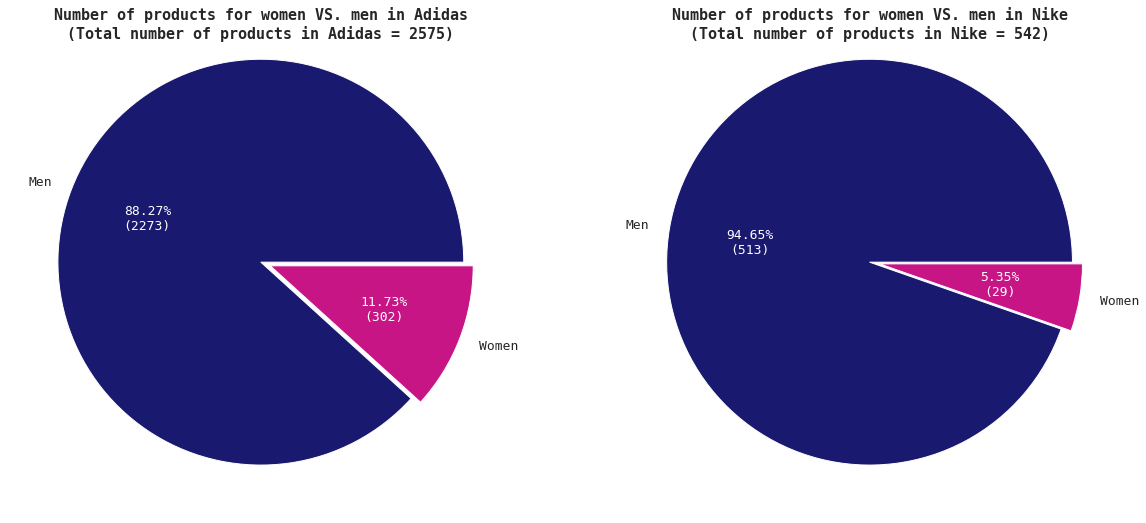

In [62]:
# for more understanding

figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
adidas = [men[men['brand']=="Adidas"]['men_products'][0], women[women['brand']=="Adidas"]['women_products'][0]]
_, _, autotexts = plt.pie(adidas, explode=[0, 0.05],
                          labels=['Men', 'Women'],
                          autopct=make_autopct(adidas), colors=["midnightblue", "mediumvioletred"],
                          textprops={"fontsize":13, "fontname": "monospace"})
for autotext in autotexts:
    autotext.set_color('white')
plt.title("Number of products for women VS. men in Adidas\n(Total number of products in Adidas = {})".format(sum(adidas)),
          fontsize=15, fontweight="bold", fontname="monospace", y=0.93)

plt.subplot(1, 2, 2)
nike = [men[men['brand']=="Nike"]['men_products'][1], women[women['brand']=="Nike"]['women_products'][1]]
_, _, autotexts = plt.pie(nike, explode=[0, 0.05],
                          labels=['Men', 'Women'],
                          autopct=make_autopct(nike), colors=["midnightblue", "mediumvioletred"],
                          textprops={"fontsize":13, "fontname": "monospace"})
plt.setp(autotexts, color="white")
#for autotext in autotexts:
#    autotext.set_color('white')
plt.title("Number of products for women VS. men in Nike\n(Total number of products in Nike = {})".format(sum(nike)),
          fontsize=15, fontweight="bold", fontname="monospace", y=0.93)

plt.show()

<div align="center">
    Despite of the huge difference in number of products between "Adidas" and "Nike", both produce approximately equal percentages of products for the same gender, and the percentage of men's products is much more than the percentage of women's products.
</div>

- - - -

## 6. Closing the connection between database and python ##

In [63]:
if cursor.close():
    print("Connection is closed successfully")

Connection is closed successfully


- - - -

## 7. Insights ##

1. This store has much more __Adidas__ products than __Nike__ products
<br>

2. __Average__ and __Expensive__ price categories achieve more revenue than __Elite__ which is the most expensive products
<br>

3. For all products, __Adidas__ has an average discount of 33.45% while __Nike__ has zero!
<br>

4. Revenue is increasing with the number of reviews which gives us an important insight:
    * People buy the product which has more number of reviews then the revenue increases
<br>


5. The best selling 2 products are from __Nike__, and they've been last visited since 2019 and 2018!
<br>

6. Product's description length doesn't affect the rating of the product that much
<br>

7. __Adidas__ prices are much more than __Nike__
<br>

8. Because of the first point, Adidas has much more number of reviews than Nike along the months of the year
<br>

9. Either for __Adidas__ or __Nike__, this store has products for men more than women
<br>

10. The store sells products for foot (85%) more than any other cloths (15%)
<br>

11. Along the quarters of the year, the first quarter (first 3 months of the year) has more number of visits for products than the other quarters for both brands __Adidas__ and __Nike__